**Imports**

In [2]:
import re
import numpy as np
import pandas as pd
import xgboost as xgb
from scipy import stats
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

In [3]:
# filling null values using spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Fill Missing Values") \
    .getOrCreate()

# Read DataFrames
df = spark.read.csv("./data/train_for_spark.csv", inferSchema=True, header=True)
#df_test = spark.read.csv("test_set.csv", inferSchema=True, header=True)

# Calculate mean of 'review_scores_rating' for both datasets
mean_rating = df.select(mean('review_scores_rating')).collect()[0][0]

# Count number of null cells in specific columns before filling
null_counts_before = {col_name: df.filter(col(col_name).isNull()).count() for col_name in ['beds', 'bedrooms', 'bathrooms', 'review_scores_rating']}

# Fill null values in multiple columns with default values
columns_to_fill = ['beds', 'bedrooms', 'bathrooms']
fill_values = {col: 1 for col in columns_to_fill}
fill_values['review_scores_rating'] = mean_rating

df = df.na.fill(fill_values)
#df_test = df_test.na.fill(fill_values)

# Count number of null cells in specific columns after filling
null_counts_after = {col_name: df.filter(col(col_name).isNull()).count() for col_name in ['beds', 'bedrooms', 'bathrooms', 'review_scores_rating']}

# Save DataFrames as CSV
# df.write.csv("/content/training_set_final.csv", header=True)
#df_test.write.csv("/content/test_set_final.csv", header=True)

# Stop SparkSession
spark.stop()

# Display null counts before and after filling
print("Null counts before filling:")
for col_name, count in null_counts_before.items():
    print(f"{col_name}: {count}")

print("\nNull counts after filling:")
for col_name, count in null_counts_after.items():
    print(f"{col_name}: {count}")


Null counts before filling:
beds: 377
bedrooms: 391
bathrooms: 202
review_scores_rating: 16266

Null counts after filling:
beds: 0
bedrooms: 0
bathrooms: 0
review_scores_rating: 0


# **Data Preprocessing**

In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
# Creating new columns for attributes from amenities column
def extract_amenities(df):
  amenities_to_check = ["Wireless Internet", "Kitchen", "Heating", "Essentials", "Smoke detector", "Air conditioning", "TV"]

  # Loop through each amenity
  for amenity in amenities_to_check:
      boolean_column_name = amenity.replace(" ", "_").lower()  # Convert amenity name to lowercase and replace spaces with underscores
      boolean_values = []  # List to store boolean values for the current amenity

      # Loop through each row in the DataFrame
      for amenities in df.amenities:
          amen = re.sub(r'(\"|\{|\})', '', amenities).split(',')
          amenity_present = False  # Initialize as False for the current row

          # Check if the current amenity is present in the amenities list for the current row
          for a in amen:
              if amenity in a:
                  amenity_present = True
                  break  # No need to continue searching if found

          # Append True or False to the list based on whether the amenity is present or not
          boolean_values.append(amenity_present)

      # Assign the boolean values list to the new column in the DataFrame
      df[boolean_column_name] = boolean_values

  # Print value counts for each boolean column
  for amenity in amenities_to_check:
      boolean_column_name = amenity.replace(" ", "_").lower()
      print(df[boolean_column_name].value_counts())
      print()



In [ ]:
extract_amenities(df)
extract_amenities(df_test)

wireless_internet
True     71265
False     2846
Name: count, dtype: int64

kitchen
True     67526
False     6585
Name: count, dtype: int64

heating
True     67073
False     7038
Name: count, dtype: int64

essentials
True     64005
False    10106
Name: count, dtype: int64

smoke_detector
True     61727
False    12384
Name: count, dtype: int64

air_conditioning
True     55210
False    18901
Name: count, dtype: int64

tv
True     53656
False    20455
Name: count, dtype: int64

wireless_internet
True     24432
False     1026
Name: count, dtype: int64

kitchen
True     23161
False     2297
Name: count, dtype: int64

heating
True     22978
False     2480
Name: count, dtype: int64

essentials
True     21915
False     3543
Name: count, dtype: int64

smoke_detector
True     21134
False     4324
Name: count, dtype: int64

air_conditioning
True     18851
False     6607
Name: count, dtype: int64

tv
True     18495
False     6963
Name: count, dtype: int64



In [ ]:
# Adjust values of review_scores_rating to decimal instead of percentage to prepare for model training
df['review_scores_rating'] = df['review_scores_rating'] / 100
df_test['review_scores_rating'] = df_test['review_scores_rating'] / 100

In [ ]:
# Trial one of deciding features to drop
#merged_df.drop(columns=["id", "amenities", "description", "cleaning_fee", "city", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "instant_bookable", "last_review", "latitude", "longitude", "name", "number_of_reviews", "review_scores_rating", "thumbnail_url", "zipcode", "neighbourhood"], inplace=True)

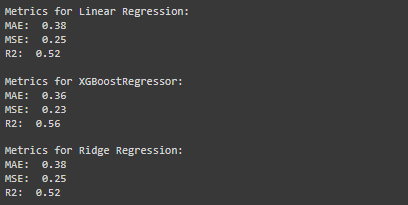

In [ ]:
# Trial two of deciding features to two (added city and cleaning fee features)
# df.drop(columns=["id", "amenities", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "instant_bookable", "last_review", "latitude", "longitude", "name", "number_of_reviews", "review_scores_rating", "thumbnail_url", "zipcode", "neighbourhood"], inplace=True)

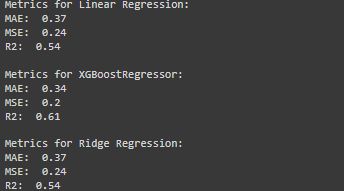

In [ ]:
# Dropping out unecessary columns ( Final descision on features to drop) (added review scores rating and number of reviews)
df.drop(columns=["id", "amenities", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "last_review", "latitude", "longitude", "name","thumbnail_url", "zipcode", "neighbourhood"], inplace=True)
df_test.drop(columns=["id", "amenities", "description", "first_review", "host_has_profile_pic", "host_identity_verified", "host_response_rate", "host_since", "last_review", "latitude", "longitude", "name","thumbnail_url", "zipcode", "neighbourhood"], inplace=True)

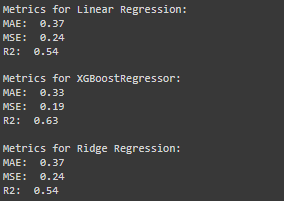

In [ ]:
# Checking if there is any null data before training to eleminate them
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   log_price             74111 non-null  float64
 1   property_type         74111 non-null  object 
 2   room_type             74111 non-null  object 
 3   accommodates          74111 non-null  int64  
 4   bathrooms             73911 non-null  float64
 5   bed_type              74111 non-null  object 
 6   cancellation_policy   74111 non-null  object 
 7   cleaning_fee          74111 non-null  bool   
 8   city                  74111 non-null  object 
 9   instant_bookable      74111 non-null  object 
 10  number_of_reviews     74111 non-null  int64  
 11  review_scores_rating  57389 non-null  float64
 12  bedrooms              74020 non-null  float64
 13  beds                  73980 non-null  float64
 14  wireless_internet     74111 non-null  bool   
 15  kitchen            

In [ ]:
# Filling in Null values in columns
df['beds'] = df['beds'].fillna(1)
df['bedrooms'] = df['bedrooms'].fillna(1)
df['bathrooms'] = df['bathrooms'].fillna(1)
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())

df_test['beds'] = df_test['beds'].fillna(1)
df_test['bedrooms'] = df_test['bedrooms'].fillna(1)
df_test['bathrooms'] = df_test['bathrooms'].fillna(1)
df_test['review_scores_rating'] = df_test['review_scores_rating'].fillna(df_test['review_scores_rating'].mean())

df.info()

In [ ]:
# Encoding the categorical variables using LabelEncoder
le = LabelEncoder()
df_encoded = df.copy()  # Create a copy of the DataFrame to avoid modifying the original data

for col in df.select_dtypes(include=['object','bool']):
    df_encoded[col] = le.fit_transform(df[col])

for col in df_test.select_dtypes(include=['object', 'bool']):
     df_test[col] = le.fit_transform(df_test[col])

df_encoded.head()

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,instant_bookable,number_of_reviews,review_scores_rating,bedrooms,beds,wireless_internet,kitchen,heating,essentials,smoke_detector,air_conditioning,tv
0,5.010635,0,0,3,1.0,4,2,1,4,0,2,1.000000,1.0,1.0,1,1,1,1,0,1,0
1,5.129899,0,0,7,1.0,4,2,1,4,1,6,0.930000,3.0,3.0,1,1,1,1,1,1,0
2,4.976734,0,0,5,1.0,4,1,1,4,1,10,0.920000,1.0,3.0,1,1,1,1,1,1,1
3,6.620073,17,0,4,1.0,4,0,1,5,0,0,0.940674,2.0,2.0,1,1,1,1,1,0,1
4,4.744932,0,0,2,1.0,4,1,1,2,1,4,0.400000,0.0,1.0,1,1,1,1,1,1,1


In [ ]:
#splitting train dataset to validate
df_train, df_test_cv  = train_test_split(df_encoded,test_size=0.25,random_state = 101)

# **Model Training**

In [ ]:
# Linear Regression
lin_reg = LinearRegression()
X=df_train.drop(['log_price'],axis=1)
Y=df_train['log_price']
kf = KFold(n_splits=5, shuffle=True, random_state = 101)

print(cross_val_score(lin_reg, X, Y, # estimator, features, target
                cv=5, # number of folds
                scoring='r2'))

print(np.mean(cross_val_score(lin_reg, X, Y, cv=kf, scoring='r2')))
print(f"MSE:  {np.mean(cross_val_score(lin_reg, X, Y, cv=kf, scoring='neg_mean_absolute_error'))}")


[0.52964899 0.52537719 0.53143671 0.54001691 0.53634739]
0.5325493588216463
MSE:  -0.3695813195355043


In [ ]:
#XGBRegressor
lm_xgb = xgb.XGBRegressor()

print(cross_val_score(lm_xgb, X, Y, # estimator, features, target
                cv=5, # number of folds
                scoring='r2'))

print(np.mean(cross_val_score(lm_xgb, X, Y, cv=kf, scoring='r2')))
print(f"MSE:  {np.mean(cross_val_score(lm_xgb, X, Y, cv=kf, scoring='neg_mean_absolute_error'))}")

[0.62305328 0.60855824 0.62131281 0.63034473 0.61585052]
0.6191195616273755
MSE:  -0.33140392412074593


In [ ]:
#Ridge
lm_reg = Ridge(alpha=1)

print(cross_val_score(lm_reg, X, Y, # estimator, features, target
                cv=5, # number of folds
                scoring='r2'))

print(np.mean(cross_val_score(lm_reg, X, Y, cv=kf, scoring='r2')))
print(f"MSE:  {np.mean(cross_val_score(lm_reg, X, Y, cv=kf, scoring='neg_mean_absolute_error'))}")


[0.52965172 0.52538158 0.53143969 0.5400118  0.53634294]
0.5325495531899367
MSE:  -0.3695820378069582


In [3]:
# best features to use
df = pd.read_csv('Data/cleaned_train_2.csv')
X = df.drop(columns=['log_price'])  # Features
y = df['log_price']  # Target variable

#Split the data into training and testing sets
X_train, X_test2, y_train, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's assume you have already loaded and split your data into X_train, X_test, y_train, y_test

# Define a list of models to try
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Support Vector Regressor": SVR(),
    "XGBoost Regressor": XGBRegressor() # highest r2 score
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    

# Display the results
# results_df = pd.DataFrame(results)
# print(results_df)

# **Results and Evaluation of Models Predictions**

In [5]:
def show_metrics(prediction_test, y_test):
    MAE = round(metrics.mean_absolute_error(y_test, prediction_test), 2)
    MSE = round(metrics.mean_squared_error(y_test, prediction_test), 2)
    r2_score = round(metrics.r2_score(y_test, prediction_test),2)
    print("MAE: ", MAE)
    print("MSE: ", MSE)
    print("R2: ", r2_score)

In [ ]:
# Prepare the test dataset
X_test = df_test_cv.drop(['log_price'], axis=1)
y_test = df_test_cv['log_price']

# Train Linear Regression model
lin_reg.fit(X, Y)
prediction_test_lin_reg = lin_reg.predict(X_test)
# prediction_train_lin_reg = lin_reg.predict(X)

# Train XGBoostRegressor model
lm_xgb.fit(X, Y)
prediction_test_lm_xgb = lm_xgb.predict(X_test)
# prediction_train_lm_xgb = lm_xgb.predict(X)

# Train Ridge Regression model
lm_reg.fit(X, Y)
prediction_test_lm_reg = lm_reg.predict(X_test)

# prediction_train_lm_reg = lm_reg.predict(X)

# Call show_metrics function for each model
print("Metrics for Linear Regression:")
show_metrics(prediction_test_lin_reg, y_test)

print("\nMetrics for XGBoostRegressor:")
show_metrics(prediction_test_lm_xgb, y_test)

print("\nMetrics for Ridge Regression:")
show_metrics(prediction_test_lm_reg, y_test)


Metrics for Linear Regression:
MAE:  0.37
MSE:  0.24
R2:  0.54

Metrics for XGBoostRegressor:
MAE:  0.33
MSE:  0.19
R2:  0.63

Metrics for Ridge Regression:
MAE:  0.37
MSE:  0.24
R2:  0.54


In [6]:
for name, model in models.items():
    y_pred = model.predict(X_test2)
    print(f"Metrics for {name}:")
    show_metrics(y_pred, y_test2)



Metrics for Linear Regression:
MAE:  0.36
MSE:  0.23
R2:  0.56
Metrics for Random Forest Regressor:
MAE:  0.28
MSE:  0.15
R2:  0.71
Metrics for Gradient Boosting Regressor:
MAE:  0.3
MSE:  0.17
R2:  0.67
Metrics for Support Vector Regressor:
MAE:  0.35
MSE:  0.23
R2:  0.55
Metrics for XGBoost Regressor:
MAE:  0.28
MSE:  0.15
R2:  0.71


In [ ]:
# print the price prediction instead of log_price prediction for prediction_test_lm_xgb ( subset of train data)
prediction_test_lm_xgb = np.exp(prediction_test_lm_xgb)
print(prediction_test_lm_xgb[0:10])


[ 73.614845 192.89307  172.71729   86.35676   67.329155  75.410324
  67.43519  214.0124   126.80735   74.93805 ]


In [ ]:
# User input prediction ( user should put input in test.csv file)
predictions = np.exp(lm_xgb.predict(df_test))
print(predictions[0:10])


[ 63.819683 148.76735   95.89687  142.62563  169.69913   91.984375
 230.80785  192.01476  181.6435    66.80735 ]
